In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import math
import heapq
import sys
import statistics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

Create some clustered data.

In [2]:
#generate dummy cluster datasets
# Set three centers
center_1 = np.array([1,1])
center_2 = np.array([5,5])
center_3 = np.array([8,1])

rd.seed(42)

# Generate random data and center it to the three centers
N = 100
cluster_1 = np.random.randn(N,2) + center_1
cluster_2 = np.random.randn(N,2) + center_2
cluster_3 = np.random.randn(N,2) + center_3

data = np.concatenate((cluster_1, cluster_2, cluster_3), axis = 0)
data.shape

(300, 2)

Plot it and define a class (label).

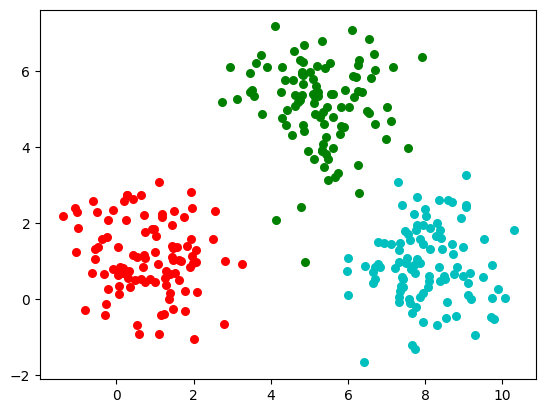

In [3]:
colors = ["r", "g", "c"]

y_data = np.zeros(data.shape[0])
idx = 0
for d in data:
    y_data[idx] = int(idx/100)
    color = colors[int(idx/100)]
    idx +=1
    plt.scatter(d[0], d[1], color = color,s = 30)

Function to calculate the euclidean distance of datapoints.

In [4]:
def euclidean_distance(point1, point2):
    #return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)   #sqrt((x1-x2)^2 + (y1-y2)^2)
    return np.linalg.norm(point1-point2, axis=0)

Synthetic data consists of clones (avatars) of the originla data. Each clone of datapoint $d$ is the centroid of its $k$ nearest neighbours.

In [5]:
k=10
clones = np.zeros((1,2))
for d1 in data:
    distances = []
    for d2 in data:
        if (d1==d2).all():
            distances.append(sys.float_info.max)
        else:
            distances.append(euclidean_distance(d1,d2))
    smallest = heapq.nsmallest(k, distances)
    clone = np.zeros((1,2))
    for s in smallest:
        idx = distances.index(s)
        clone = clone + data[idx]
    clone = clone/k
    clones = np.concatenate((clones, clone), axis = 0)
clones = np.delete(clones, (0), axis=0)
clones.shape

(300, 2)

Plot the synthetic data.

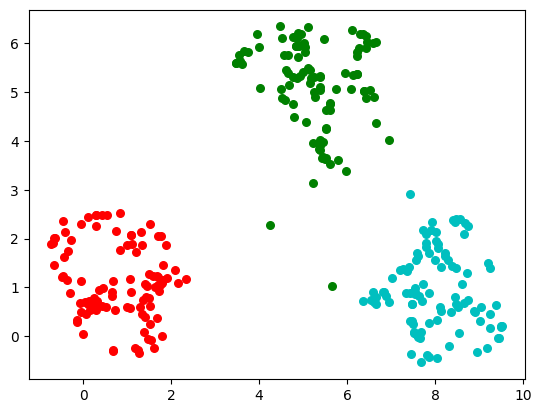

In [6]:
y_clones = np.zeros(clones.shape[0])
idx =0
for d in clones:
    y_clones[idx] = int(idx/100)
    color = colors[int(idx/100)]
    idx +=1
    plt.scatter(d[0], d[1], color = color,s = 30)

Test the data with Naive Bayesian classifier trained with the sythetic data.

In [7]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training with clones
model.fit(clones, y_clones)

GaussianNB()

Classify the original data.

In [8]:
y_pred = model.predict(data)
accuray = accuracy_score(y_pred, y_data)
f1 = f1_score(y_pred, y_data, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.9966666666666667
F1 Score: 0.9966667500020833


Evaluate the accuracy of the classifier.

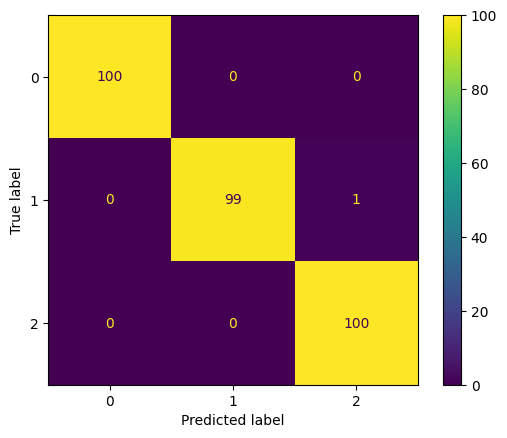

In [9]:
labels = [0,1,2]
cm = confusion_matrix(y_data, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

Compare it with training accuracy on the original data.

In [10]:
# Build a Gaussian Classifier
model2 = GaussianNB()

# Model training with data
model2.fit(data, y_data)

y_pred = model2.predict(data)
accuray = accuracy_score(y_pred, y_data)
f1 = f1_score(y_pred, y_data, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.9966666666666667
F1 Score: 0.9966667500020833


Test of risks of identification, correlation, inference (data governance g29 rules). Here: distance and rank of distance of clone to original datapoint in the list of distances of clone to all data points (higher distances/ranks are better).

In [24]:
ranks = np.zeros(clones.shape[0])
the_distances = np.zeros(clones.shape[0])
idx = 0
for d1 in clones:
    distances = []
    the_distance = euclidean_distance(d1,data[idx, :])
    for d2 in data:
        distances.append(euclidean_distance(d1,d2))
    smallest = np.sort(distances).tolist()
    ranks[idx] = smallest.index(the_distance)+1
    the_distances[idx] = the_distance
    idx += 1
print("Median rank: "+str(statistics.median(ranks)))
print("Mean rank: "+str(statistics.mean(ranks)))
print("First ranked: "+str(np.count_nonzero(ranks == 1)/(3*N)*100)+"%")
print("Median distances: "+str(statistics.median(the_distances)))
print("Mean distances: "+str(statistics.mean(the_distances)))
epsilon = 0.01
print("Almost zero distances: "+str(np.count_nonzero(the_distances < epsilon)/(3*N)*100)+"%")

Median rank: 2.0
Mean rank: 3.5366666666666666
First ranked: 40.666666666666664%
Median distances: 0.1788839164942094
Mean distances: 0.2550751258637599
Almost zero distances: 0.0%


Plot the distributions of ranks and distances.

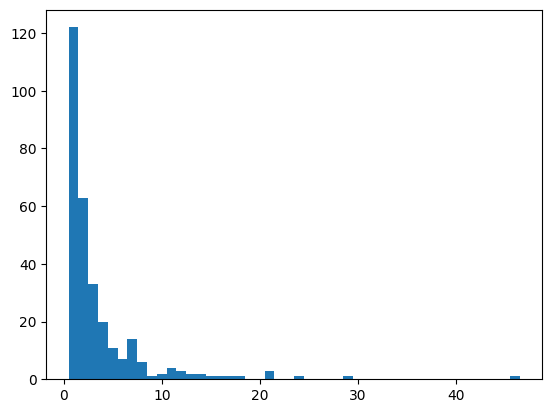

In [12]:
d = np.diff(np.unique(ranks)).min()
left_of_first_bin = ranks.min() - float(d)/2
right_of_last_bin = ranks.max() + float(d)/2
plt.hist(ranks, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.show()

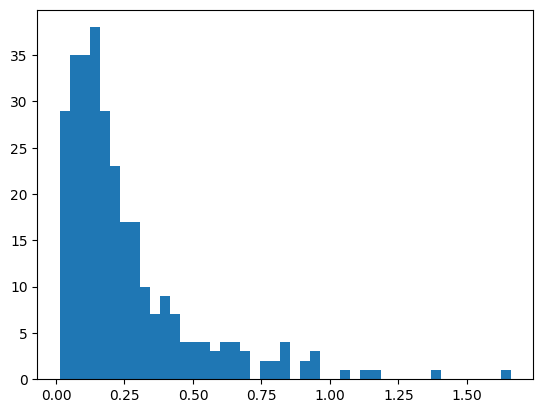

In [17]:
plt.hist(the_distances, bins=45)
plt.show()